In [1]:
cd /home/phucnth/aqg 

/home/phucnth/aqg


In [2]:
import torch 
import pandas as pd 
import numpy as np 
import networkx as nx
from torch_geometric.utils import from_networkx
from transformers import T5Tokenizer, AutoModelForSeq2SeqLM

from questgen.utils.file_utils import load_json_file
from graph.modules.gcnLM import GCNWithEdgeLabels
from graph.modules.extract_triples import TripleExtractor
from graph.modules.extract_features import Processor
from graph.utils.visualize_utils import visualize_graph_from_networks
from graph.modules.utils import convert_to_geometric


**Build Knowledge Graph From Dataset**

In [3]:
data = load_json_file("questgen/dataset/build_transformer_format_dataset/transformer_format/simple-question/english/mcqg_english_data_1000_v1.1.0.json")["data"]
base_sentences = np.unique([c["context"] for c in data]).tolist()
base_sentences[:5]

['"Happiness is not having what you want but wanting what you have," according to James Stewart. Although scientists now under-stand the roots of depression more clearly than they used to, happiness still remains a mystery. Recently, however, some interesting discoveries have been made.\nThose who say they are happy, for example, tend to be less self-centred, less hostile and abusive, and are less prone to disease and general ill health. Interestingly, the affluent are not notably happier than their less-well-off counterparts, and seemingly, no particular time of life is significantly happier than any other. Even though some people see life as a tragedy, when questioned, most people said they were generally happy - painting a much rosier picture regarding people\'s general and dispositions.\nResearch has shown that people have two basic reward centres in their brains that are stimulated by two different chemicals which cause happiness. The first, dopamine, is triggered by activities li

In [4]:
extractor = TripleExtractor(lang="en", type="spacy")
kg_df = extractor.extract(context_list=base_sentences, return_df=True)
kg_df, data = convert_to_geometric(kg_df, return_df=True)


  0%|          | 0/210 [00:00<?, ?it/s]

In [5]:
new_df = pd.DataFrame({"source": kg_df["target"], "target": kg_df["source"], "relation": kg_df["relation"]})
kg_df = pd.concat([kg_df, new_df]).reset_index(drop=True)


In [6]:
# kg_df = pd.read_csv("graph/kg_df.csv", index_col=0).drop_duplicates()
kg_df.head()

,source,target,relation
0,how that,most goals,help
1,well snow leopard,figting chance,have
2,all university It,all world,become
3,after he,6 o'clock,think
4,always we,misery,thought


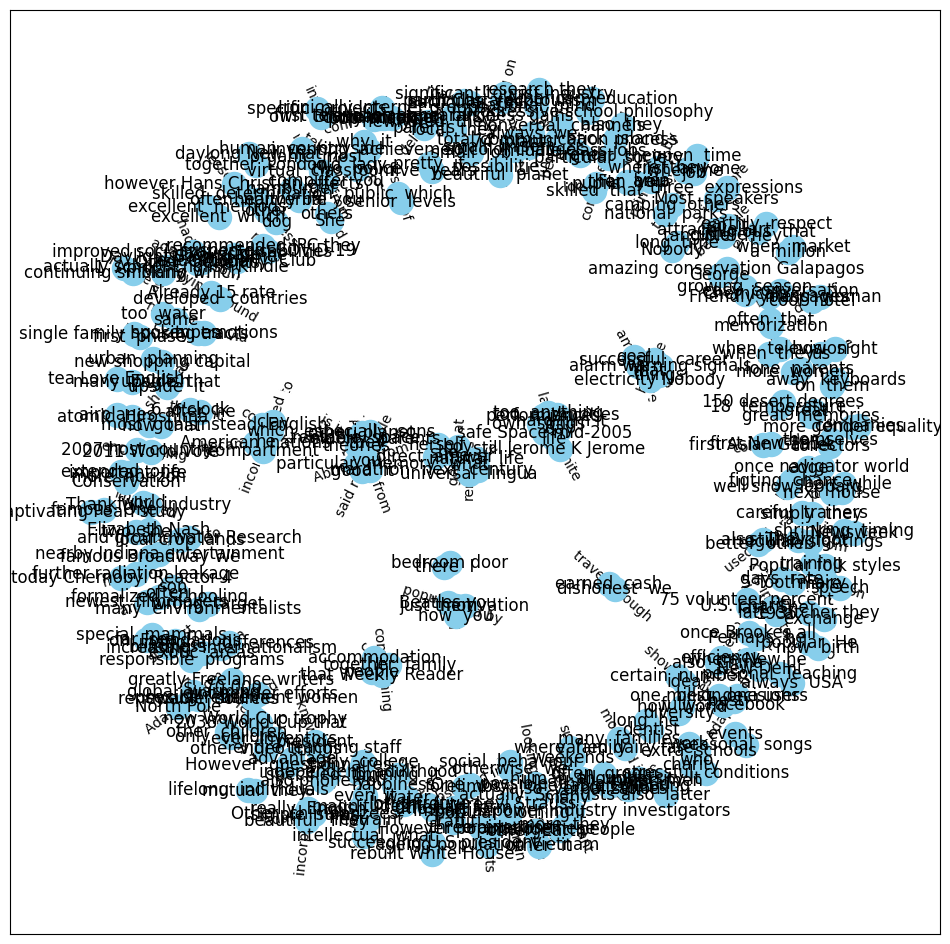

In [7]:
visualize_graph_from_networks(kg_df=kg_df)

**Extract and Mapping KG**

In [8]:
# candidate_sentences = [
#     "Sapwood is thicker in the upper portion of the trunk of a tree than near the base because the age and the diameter of the upper sections are less",
#     # "20p is commonly used for Internet distribution of high-definition video because most computer monitors operate in progressive-scan mode",
#     # "Laws about antennas were updated before the change to digital terrestrial broadcasts",
#     # "These new laws prohibit home owners' associations and city government from banning the installation of antennas.", 
#     # "Standard 35mm photographic film used for cinema projection has a much higher image resolution than HDTV systems and is exposed and projected at a rate of 24 frames per second (frame/s)"
# ]
candidate_sentences = kg_df[-5:]
candidate_sentences.head()

,source,target,relation
415,atomic Hiroshima,airplanes,lived
416,all world,O. stories,translated
417,all world,O. stories,translated
418,social behaviour,otherwise we,spend
419,small job,small I,makes


In [9]:
current_kg_df, current_data = convert_to_geometric(candidate_sentences, return_df=True)
current_new_df = pd.DataFrame({"source": current_kg_df["target"], "target": current_kg_df["source"], "relation": current_kg_df["relation"]})


In [10]:
current_new_df.head(5)

,source,target,relation
415,airplanes,atomic Hiroshima,lived
416,O. stories,all world,translated
417,O. stories,all world,translated
418,otherwise we,social behaviour,spend
419,small I,small job,makes


In [11]:
kg_df.head(5)

,source,target,relation
0,how that,most goals,help
1,well snow leopard,figting chance,have
2,all university It,all world,become
3,after he,6 o'clock,think
4,always we,misery,thought


In [12]:
mapping_src = kg_df[kg_df["source"].isin(current_new_df['source'].values)].drop_duplicates().reset_index(drop=True)
mapping_tgt = kg_df[kg_df["target"].isin(current_new_df['target'].values)].drop_duplicates().reset_index(drop=True)
mapping_rel = kg_df[kg_df["relation"].isin(current_new_df['relation'].values)].drop_duplicates().reset_index(drop=True)

# print(mapping_src)
# print("\n", mapping_tgt)
print("\n", mapping_rel)


               source             target    relation
0          airplanes  atomic  Hiroshima       lived
1         O. stories         all  world  translated
2      otherwise  we  social  behaviour       spend
3           small  I         small  job       makes
4  atomic  Hiroshima          airplanes       lived
5         all  world         O. stories  translated
6  social  behaviour      otherwise  we       spend
7         small  job           small  I       makes


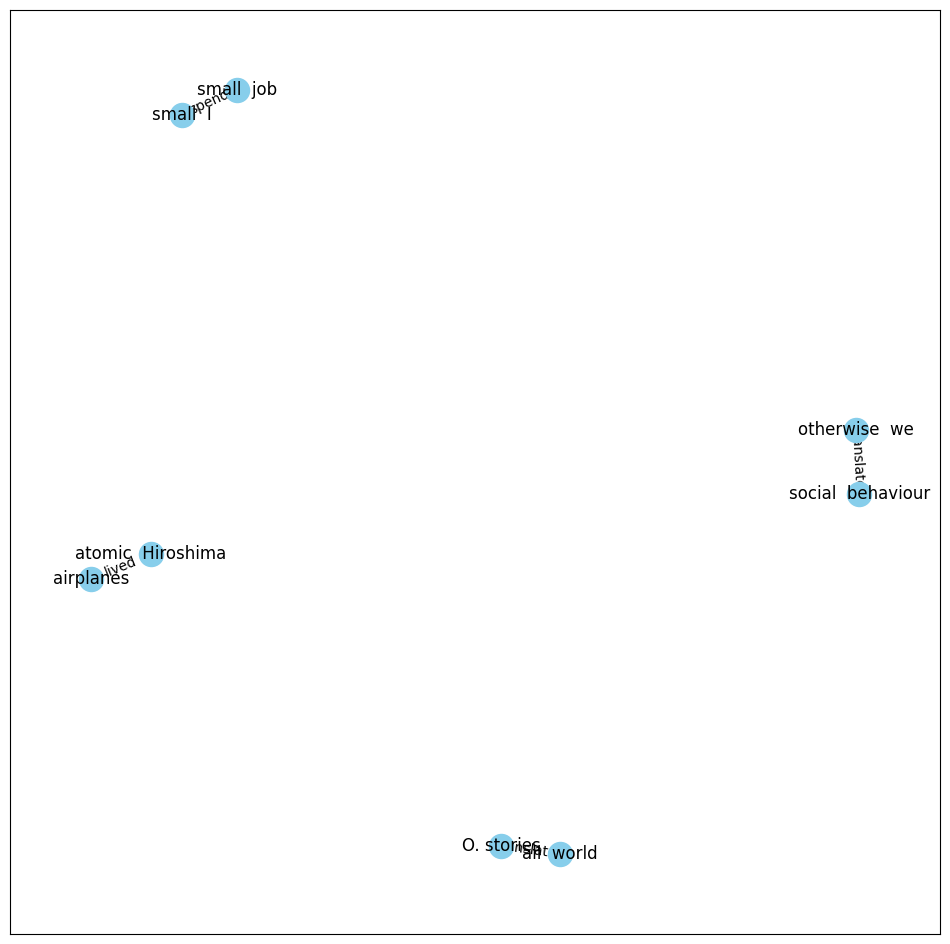

In [13]:
visualize_graph_from_networks(kg_df=current_new_df)

In [14]:
lm_model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")
tokenizer = T5Tokenizer.from_pretrained("t5-small")

In [15]:
processor = Processor(tokenizer=tokenizer, model=lm_model)
nodes_features = processor.process(mapping_rel["source"], aggre=({'use':False, 'axis': 1}))
tgt_features = processor.process(mapping_rel["target"], aggre=({'use':False, 'axis': 1}))
rel_features = processor.process(mapping_rel["relation"], aggre=({'use':True, 'axis': 1}))

print(nodes_features.shape)
print(tgt_features.shape)
print(rel_features.shape)

(8, 32, 512)
(8, 32, 512)
(8, 512)


In [16]:
rel_features = torch.randn(8)
rel_features.shape

torch.Size([8])

In [17]:
G=nx.from_pandas_edgelist(df=current_new_df, source="source", target="target", edge_attr=True) # create_using=nx.MultiDiGraph())
data = from_networkx(G)
data.relation

['lived',
 'lived',
 'translated',
 'translated',
 'spend',
 'spend',
 'makes',
 'makes']

In [18]:
data.edge_index

tensor([[0, 1, 2, 3, 4, 5, 6, 7],
        [1, 0, 3, 2, 5, 4, 7, 6]])

In [19]:

data.edge_relation = rel_features
data.node_features = nodes_features
# data.relation = tgt_features


In [20]:
data.edge_stores

[{'edge_index': tensor([[0, 1, 2, 3, 4, 5, 6, 7],
         [1, 0, 3, 2, 5, 4, 7, 6]]), 'relation': ['lived', 'lived', 'translated', 'translated', 'spend', 'spend', 'makes', 'makes'], 'num_nodes': 8, 'edge_relation': tensor([ 1.2441,  1.4063, -0.4311,  1.1642, -0.3907,  0.6773,  0.2485, -0.0220]), 'node_features': array([[[-0.02248303,  0.07454386, -0.04352553, ...,  0.07582174,
          -0.0961333 ,  0.0291612 ],
         [ 0.02210739,  0.00307553, -0.00946827, ...,  0.01109885,
          -0.008031  ,  0.00378453],
         [ 0.00979885,  0.14379612, -0.0115343 , ...,  0.07613753,
           0.14112748,  0.14551845],
         ...,
         [ 0.04855945,  0.15561286,  0.11222199, ..., -0.00134207,
           0.03488784, -0.00265107],
         [ 0.04855945,  0.15561286,  0.11222199, ..., -0.00134207,
           0.03488784, -0.00265107],
         [ 0.04855945,  0.15561286,  0.11222199, ..., -0.00134207,
           0.03488784, -0.00265107]],
 
        [[ 0.03848527,  0.17828934, -0.002217

In [21]:
data

Data(edge_index=[2, 8], relation=[8], num_nodes=8, edge_relation=[8], node_features=[8, 32, 512])

In [22]:
edge_index = data.edge_index
edge_relation = torch.tensor(data.edge_relation)

# replace (8, 768) to (8, 512, 768) to test input model
data.node_features = torch.randn(8, 64, 768) #data.num_nodes
node_features = data.node_features

print("edge_index:", edge_index)
print("edge_relation:", edge_relation)

print(data)


edge_index: tensor([[0, 1, 2, 3, 4, 5, 6, 7],
        [1, 0, 3, 2, 5, 4, 7, 6]])
edge_relation: tensor([ 1.2441,  1.4063, -0.4311,  1.1642, -0.3907,  0.6773,  0.2485, -0.0220])
Data(edge_index=[2, 8], relation=[8], num_nodes=8, edge_relation=[8], node_features=[8, 64, 768])


/home/phucnth/miniconda3/aqg/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


**Graph Convolution Network**


In [23]:
# create an instance of the GCN model
model = GCNWithEdgeLabels(in_channels=768, hidden_channels=6, out_channels=768)

out = model(x=node_features, edge_index=edge_index, edge_attr=edge_relation)
print(out.shape)

torch.Size([8, 64, 768])


In [24]:

node_features = torch.randn(8, 64, 768)
edge_index = torch.randint(1, 8, (2, 8))
edge_relation = torch.randn(8)

out = model(x=node_features, edge_index=edge_index, edge_attr=edge_relation)
print(out.shape)

torch.Size([8, 64, 768])
